Note that, to run this notebook, you will need to install pyDRTtools. I have done so by cloning the repo and using pip install -e.

In [1]:
import pyDRTtools
from pyDRTtools import runs

from nanodrt.drt_solver.drt import DRT
from nanodrt.fitting.optimizer import Optimizer
from nanodrt.drt_solver.measurements import ImpedenceMeasurement
from nanodrt.drt_solver.utils import (ZARC, 
                                 gamma_ZARC)
from nanodrt.plotting.plots import Plot

import jax.numpy as jnp 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Union

import seaborn as sns

In [2]:
def plot_fit_comparison(
    f: Union[np.ndarray, jnp.ndarray], 
    Z_measured_re: Union[np.ndarray, jnp.ndarray], 
    Z_measured_im: Union[np.ndarray, jnp.ndarray], 
    tau_list: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]], 
    gamma_list: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]], 
    labels: Union[str, List[str]] = None, 
    Z_fit_re: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]] = None, 
    Z_fit_im: Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]] = None
) -> None:
    """
    Plot DRT Spectrum and Nyquist plot.

    Args:
        f (Union[np.ndarray, jnp.ndarray]): Range of frequencies used to determine integrand values.
        Z_measured_re (Union[np.ndarray, jnp.ndarray]): Real part of measured impedance.
        Z_measured_im (Union[np.ndarray, jnp.ndarray]): Imaginary part of measured impedance.
        tau_list (Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]]): List of tau arrays for multiple data sets or a single tau array.
        gamma_list (Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]]): List of gamma arrays for multiple data sets or a single gamma array.
        labels (Union[str, List[str]], optional): List of labels for each tau and gamma set or a single label. Defaults to None.
        Z_fit_re (Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]], optional): List of real parts of fitted impedance or a single array. Defaults to None.
        Z_fit_im (Union[Union[np.ndarray, jnp.ndarray], List[Union[np.ndarray, jnp.ndarray]]], optional): List of imaginary parts of fitted impedance or a single array. Defaults to None.

    Returns:
        None
    """

    # Ensure tau_list and gamma_list are lists of arrays
    if isinstance(tau_list, (np.ndarray, jnp.ndarray)) and tau_list.ndim == 1:
        tau_list = [tau_list]
    if isinstance(gamma_list, (np.ndarray, jnp.ndarray)) and gamma_list.ndim == 1:
        gamma_list = [gamma_list]

    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(tau_list))]
    elif isinstance(labels, str):
        labels = [labels]

    if Z_fit_re is None:
        Z_fit_re = []
    elif isinstance(Z_fit_re, (np.ndarray, jnp.ndarray)) and Z_fit_re.ndim == 1:
        Z_fit_re = [Z_fit_re]
    if Z_fit_im is None:
        Z_fit_im = []
    elif isinstance(Z_fit_im, (np.ndarray, jnp.ndarray)) and Z_fit_im.ndim == 1:
        Z_fit_im = [Z_fit_im]

    # Set the Seaborn style to "whitegrid" for a clean look
    sns.set(style="whitegrid", font="Times New Roman", font_scale=1.5)
    
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    # Iterate over the tau and gamma lists to plot multiple data sets
    for tau, gamma, label in zip(tau_list, gamma_list, labels):
        axs[0].plot(
            tau,
            gamma,
            "-o",
            linewidth=2,
            label=label
        )
    
    # Set labels and title for the first subplot
    axs[0].set_xlabel(r"$\tau \ (s)$", fontsize=16)
    axs[0].set_ylabel(r"$\gamma(\ln\tau) \ (\Omega)$", fontsize=16)
    axs[0].set_title("DRT Spectrum", fontsize=20)
    axs[0].legend(fontsize=16, frameon=False, loc="best")  # Add legend to the first subplot

    # Set x-axis to logarithmic scale
    axs[0].set_xscale("log")

    # Plotting the simulated data
    for Z_re, Z_im, label in zip(Z_fit_re, Z_fit_im, labels):
        axs[1].plot(Z_re, -Z_im, label=label, linewidth=2)

    # Plotting the exact data with markers
    axs[1].plot(
        Z_measured_re,
        -Z_measured_im,
        "o",
        label="Exact Data",
        color="red",
        markersize=6,
    )

    # Set labels and title for the second subplot
    axs[1].set_aspect('equal', adjustable='datalim')  # Ensure aspect ratio is equal
    axs[1].set_xlabel(r"$Z_{re}$ ($\Omega$)", fontsize=16)
    axs[1].set_ylabel(r"$-Z_{im}$ ($\Omega$)", fontsize=16)
    axs[1].set_title("Fitted and Extracted Impedance Values", fontsize=20)

    # Add a legend to the second subplot
    axs[1].legend(fontsize=16, frameon=False, loc="best")

    # Remove top and right spines for a cleaner look
    sns.despine()

    # Adjust the figure layout for better spacing
    fig.tight_layout()

    # Save the plot with high resolution
    # plt.savefig("nature_journal_combined_plot.png", dpi=300)

    # Display the plot
    plt.show()

In [3]:
# Upload the Data and create a Measurement Object 

#columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("data/single_ZARC.csv")

#df = pd.read_csv("data/ed_data_1.csv",)

# nanoDRT

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


0.029192093282869053


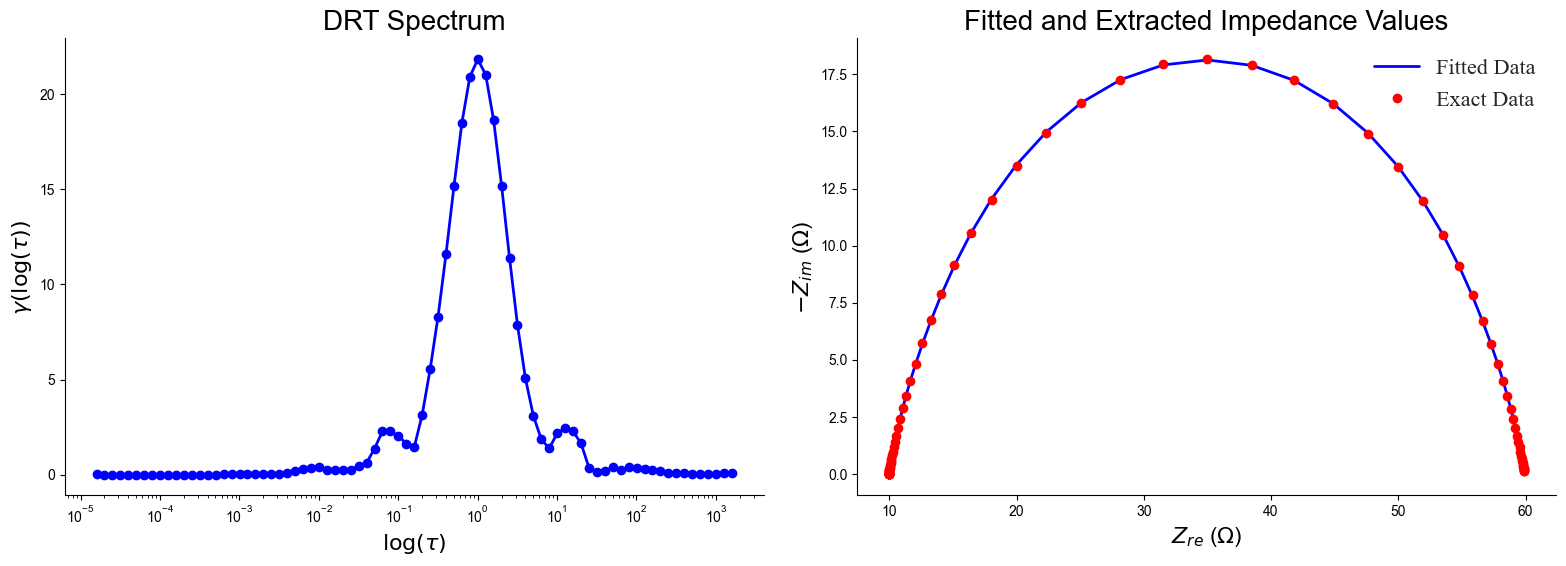

In [4]:
# nanoDRT

f = df["f"].values
tau = 1./(2*jnp.pi*f)
#tau = jnp.flip(jnp.logspace(np.log(tau.min()), np.log(tau.max()), 70))

Z_exact_re =  df["Z_re"].values 
Z_exact_im =  df["Z_im"].values

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

# Create initial gamma guess
gamma_guess = gamma_ZARC(tau, R_ct=33, tau_0=.2, phi= .7) # Guessing function for the DRT initially assume a guassian single ZARC Model 

# Create initial DRT object
drt = DRT(R_inf= 10, L_0=0, gamma=gamma_guess, tau=tau)

# Build optimiser
solver_dict = {"init_lbd": 1e-4, "lbd_selection": None, 'maxiter': 5e4}
optim = Optimizer(drt=drt, measurement=measurement, solver="regression", integration_method="rbf", solver_dict = solver_dict, rbf_function="guassian")
final_sim = optim.run()
print(final_sim.value)

# Plot result
plot = Plot(final_sim, measurement)
plot.show()

# extract values for comparison

#plot_fit_comparison(f=df["f"].values,Z_measured_re=df["Z_re"].values, Z_measured_im=df["Z_im"].values, tau_list=tau, gamma_list = gamma, Z_fit_re=DRT_Re_Z_data, Z_fit_im=DRT_Im_Z_data, labels = "pyDRTtools")

In [5]:
type(final_sim)
#print(final_sim)
from nanodrt.plotting.plots import Plot

FittedSpectrum(params=[ 9.97732153e+00  3.24972144e-07 -6.84960900e-02  5.83817666e-02
 -1.22986313e-02  1.16447089e-03 -8.23422307e-03 -4.34501769e-03
 -3.32993226e-02 -8.27524041e-02 -2.50181883e-02  1.62454313e-01
  1.31486833e-01  2.23648567e-01  1.83393745e-01 -3.07327759e-01
 -7.78070272e-02 -3.36286882e-01  7.51027519e-02  9.17116428e-02
  3.48108121e-03  1.23364526e+00 -1.51063679e+00 -1.61795665e+00
  1.55150673e+00  6.49455454e-01  1.14372212e+00  1.92051896e+00
  3.17563674e+00  5.01943371e+00  7.35028822e+00  9.90370681e+00
  1.22103778e+01  1.38434423e+01  1.43949685e+01  1.37549254e+01
  1.21137672e+01  9.85922765e+00  7.47518095e+00  5.32901144e+00
  3.53708215e+00  2.01635146e+00  5.84891416e-01 -1.10086140e+00
 -1.33949460e+00  1.46935691e+00  1.65056050e+00  8.43883371e-01
 -2.81249784e-01 -3.68621260e-01 -9.06037227e-02  1.48572694e-01
 -1.63130690e-01  1.23087013e-01 -2.93396061e-01  1.96861138e-01
  2.24674937e-01  1.43439188e-01  1.79810387e-02 -3.97123557e-02
 -3

# pyDRTtools

In [6]:
# Load measurement data into EIS_object
pyDRTtools_EIS_object = pyDRTtools.runs.EIS_object(df["f"].values, df["Z_re"].values, df["Z_im"].values)
# this includes tau definition of 
# # self.tau = 1/freq # we assume that the collocation points equal to 1/freq as default
# # self.tau_fine  = np.logspace(log10(self.tau.min())-0.5,log10(self.tau.max())+0.5,10*freq.shape[0])  

# print(pyDRTtools_EIS_object.Z_prime.shape[0])
# print(pyDRTtools_EIS_object.Z_double_prime.shape)
# print(pyDRTtools_EIS_object.freq.shape)
# print(pyDRTtools_EIS_object.Z_exp)

# ridge regression DRT
fitted_entry = pyDRTtools.runs.simple_run(entry=pyDRTtools_EIS_object, rbf_type = 'Gaussian', data_used = 'Combined Re-Im Data', induct_used = 0, der_used = '1st order', cv_type = 'custom', reg_param = 1E-4, shape_control = 'FWHM Coefficient', coeff = 0.333)

#extract fit
out_tau_vec = fitted_entry.out_tau_vec
x = fitted_entry.x
gamma = fitted_entry.gamma
DRT_Re_Z_data = fitted_entry.mu_Z_re
DRT_Im_Z_data = fitted_entry.mu_Z_im
Z_DRT = DRT_Re_Z_data + 1j*DRT_Im_Z_data
residuals_real = 100*fitted_entry.res_re/np.abs(Z_DRT)
residuals_imag = 100*fitted_entry.res_im/np.abs(Z_DRT)
series_R = fitted_entry.R
series_L = fitted_entry.L 

# something is up obviously. check on how i have been passing data to simple_run in python file. 
# looks like it might work fine with my experimental data? why not with ZARC data? 

print(len(df["f"].values))
print(len(x))
print(len(gamma), len(out_tau_vec))
print(len(DRT_Re_Z_data))

plot_fit_comparison(f=df["f"].values,Z_measured_re=df["Z_re"].values, Z_measured_im=df["Z_im"].values, tau_list=out_tau_vec, gamma_list = gamma, Z_fit_re=DRT_Re_Z_data, Z_fit_im=DRT_Im_Z_data, labels = "pyDRTtools")

custom
     pcost       dcost       gap    pres   dres
 0: -1.1610e+05 -1.1655e+05  1e+03  1e+01  4e-03
 1: -1.1609e+05 -1.1622e+05  2e+02  8e-01  3e-04
 2: -1.1610e+05 -1.1612e+05  2e+01  5e-15  2e-16
 3: -1.1611e+05 -1.1611e+05  3e+00  4e-15  2e-16
Terminated (singular KKT matrix).
here is x
None


ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
tau = 1/f # we assume that the collocation points equal to 1/freq as defau
tau_fine  = np.logspace(np.log10(tau.min())-0.5,np.log10(tau.max())+0.5,10*f.shape[0])  
#tau_fine

In [ ]:
np.log10(tau.min())

In [ ]:
np.log(1e16)

In [ ]:
A23 = np.array([[1,2,3],
              [1,2,3]])
x = np.array([1,2,3])
x = x.transpose()
np.dot(A23,x)
np.matmul(A23,x)
np.transpose(x)

In [ ]:
len(df[:])